In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib


In [2]:
df_users = pd.read_csv('users'+'.csv',sep=';')
df_ratings = pd.read_csv('ratings'+'.csv',sep=';')
df_movies = pd.read_csv('movies.csv', sep=';', encoding='ISO-8859-1').drop(['Unnamed: 3'],axis=1)

df_merged = pd.merge(df_ratings, df_users, on='userId')
df_merged = pd.merge(df_merged, df_movies, on='movieId')
df_merged

,userId,movieId,rating,timestamp,gender,age,occupation,zip-code,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000204,5949,2198,5,958846401,M,18,17,47901,Modulations (1998),Documentary
1000205,5675,2703,3,976029116,M,35,14,30030,Broken Vessels (1998),Drama
1000206,5780,2845,1,958153068,M,18,17,92886,White Boys (1999),Drama
1000207,5851,3607,5,957756608,F,18,20,55410,One Little Indian (1973),Comedy|Drama|Western


# Use a content-based filtering approach
In the case of content-based filtering, we only need to calculate the similarity score between a selected movie and other movies based on their genres. Other columns such as user demographics (gender, age, occupation, zip-code) and movie attributes (title, genres) are not directly relevant to the collaborative filtering algorithm.

In [3]:
# Extract the genres
selected_movie = 'Toy Story (1995)'
selected_movie_genres = df_movies.loc[df_movies['title'] == selected_movie, 'genres'].iloc[0].split('|')
selected_movie_genres

['Animation', "Children's", 'Comedy']

In [4]:
# select the movies with the same genres
similar_movies = df_movies[df_movies['genres'].apply(lambda x: any(genre in x.split('|') for genre in selected_movie_genres))].copy()
similar_movies

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3858,3928,Abbott and Costello Meet Frankenstein (1948),Comedy|Horror
3859,3929,"Bank Dick, The (1940)",Comedy
3873,3943,Bamboozled (2000),Comedy
3874,3944,Bootmen (2000),Comedy|Drama


In [5]:
# calc similarity score based on genres
similar_movies['similarity_score'] = similar_movies['genres'].apply(lambda x: len(set(x.split('|')).intersection(selected_movie_genres)) / len(set(x.split('|')).union(selected_movie_genres)))
similar_movies

,movieId,title,genres,similarity_score
0,1,Toy Story (1995),Animation|Children's|Comedy,1.000000
1,2,Jumanji (1995),Adventure|Children's|Fantasy,0.200000
2,3,Grumpier Old Men (1995),Comedy|Romance,0.250000
3,4,Waiting to Exhale (1995),Comedy|Drama,0.250000
4,5,Father of the Bride Part II (1995),Comedy,0.333333
...,...,...,...,...
3858,3928,Abbott and Costello Meet Frankenstein (1948),Comedy|Horror,0.250000
3859,3929,"Bank Dick, The (1940)",Comedy,0.333333
3873,3943,Bamboozled (2000),Comedy,0.333333
3874,3944,Bootmen (2000),Comedy|Drama,0.250000


In [6]:
# Sort based on similarity score
similar_movies = similar_movies.sort_values('similarity_score', ascending=False)
similar_movies

,movieId,title,genres,similarity_score
0,1,Toy Story (1995),Animation|Children's|Comedy,1.000000
1050,1064,Aladdin and the King of Thieves (1996),Animation|Children's|Comedy,1.000000
2285,2354,"Rugrats Movie, The (1998)",Animation|Children's|Comedy,1.000000
2072,2141,"American Tail, An (1986)",Animation|Children's|Comedy,1.000000
3685,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Animation|Children's|Comedy,1.000000
...,...,...,...,...
151,153,Batman Forever (1995),Action|Adventure|Comedy|Crime,0.166667
680,688,Operation Dumbo Drop (1995),Action|Adventure|Comedy|War,0.166667
69,70,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller,0.142857
1197,1215,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi,0.142857


In [7]:
top_10_similar_movies = similar_movies.iloc[1:11, :][['title','genres']]

list(top_10_similar_movies['title'][:5])

['Aladdin and the King of Thieves (1996)',
 'Rugrats Movie, The (1998)',
 'American Tail, An (1986)',
 'Adventures of Rocky and Bullwinkle, The (2000)',
 'Chicken Run (2000)']

In [8]:
# Select the top 10 recommendations
top_10_similar_movies = similar_movies.iloc[1:11, :][['title','genres']]
print('Top 10 similar movies to', selected_movie, ' with generes ' ,selected_movie_genres, ' are:')
print(top_10_similar_movies.to_string(index=False))

Top 10 similar movies to Toy Story (1995)  with generes  ['Animation', "Children's", 'Comedy']  are:
                                         title                              genres
        Aladdin and the King of Thieves (1996)         Animation|Children's|Comedy
                     Rugrats Movie, The (1998)         Animation|Children's|Comedy
                      American Tail, An (1986)         Animation|Children's|Comedy
Adventures of Rocky and Bullwinkle, The (2000)         Animation|Children's|Comedy
                            Chicken Run (2000)         Animation|Children's|Comedy
                          Bug's Life, A (1998)         Animation|Children's|Comedy
                         Saludos Amigos (1943)         Animation|Children's|Comedy
                            Toy Story 2 (1999)         Animation|Children's|Comedy
                       Steamboat Willie (1940) Animation|Children's|Comedy|Musical
                       Jungle Book, The (1967) Animation|Children's|C

# Use an item-based collaborative filtering approach
In the case of item-based collaborative filtering, we only need the columns that represent the movies, the rows that represent the users, and the cell values that represent the ratings. Other columns such as user demographics (gender, age, occupation, zip-code) and movie attributes (title, genres) are not directly relevant to the collaborative filtering algorithm. However, these additional columns can be used to provide more context and information about the users and movies, which can help to improve the recommendation results or to provide more explanation for the recommendations.

In [9]:
# Create the user-item matrix
user_item_matrix = df_ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)
user_item_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Calc the cosine similarity between the movies
from sklearn.metrics.pairwise import cosine_similarity
movie_similarities = cosine_similarity(user_item_matrix)
movie_similarities

array([[1.        , 0.39034871, 0.26794263, ..., 0.09347942, 0.04282933,
        0.18269056],
       [0.39034871, 1.        , 0.24094645, ..., 0.08701306, 0.02606255,
        0.12218461],
       [0.26794263, 0.24094645, 1.        , ..., 0.0622576 , 0.01007255,
        0.097786  ],
       ...,
       [0.09347942, 0.08701306, 0.0622576 , ..., 1.        , 0.20280851,
        0.2346385 ],
       [0.04282933, 0.02606255, 0.01007255, ..., 0.20280851, 1.        ,
        0.19297221],
       [0.18269056, 0.12218461, 0.097786  , ..., 0.2346385 , 0.19297221,
        1.        ]])

In [11]:
# select a movie and find the movie_index
specific_movie = 'Toy Story (1995)'
movie_index = df_movies[df_movies['title'] == specific_movie].index[0]
print(df_movies[df_movies['title'] == specific_movie])
print('movie_index = ',movie_index)

   movieId             title                       genres
0        1  Toy Story (1995)  Animation|Children's|Comedy
movie_index =  0


In [12]:
# Get sorted indices based on similarity score
similar_movies_indices = movie_similarities[movie_index].argsort()[::-1][1:11]  # argsort return sorted indices
similar_movies_indices

array([2898, 1173,  574, 2162, 1178,   33, 1106, 1449,  346, 2374],
      dtype=int64)

In [13]:
# Select the top 10 recommendations
similar_movies = df_movies.iloc[similar_movies_indices][['title', 'genres']]
print(f'The Top 10 similar movies to "{specific_movie}" are:')
print(similar_movies.to_string(index=False))

The Top 10 similar movies to "Toy Story (1995)" are:
                         title                                      genres
          Bad Seed, The (1956)                              Drama|Thriller
Tie Me Up! Tie Me Down! (1990)                                       Drama
   Hour of the Pig, The (1993)                               Drama|Mystery
               Rounders (1998)                                 Crime|Drama
                     Star Wars  Episode V - The Empire Strikes Back (1980)
                   Babe (1995)                     Children's|Comedy|Drama
       Plutonium Circus (1995)                                 Documentary
             Love Jones (1997)                                     Romance
            Client, The (1994)                      Drama|Mystery|Thriller
       Playing by Heart (1998)                               Drama|Romance


# Machine learning approch

In [14]:
# Read and Explore
df_users.info()
df_users.describe().T
print('\n')
for column in df_users.columns:
    print (column , "unique len = " , len(df_users[column].unique()))
df_users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   userId      6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


userId unique len =  6040
gender unique len =  2
age unique len =  7
occupation unique len =  21
zip-code unique len =  3439


,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,2460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,1060


In [15]:
df_users['gender'] = df_users['gender'].apply(lambda x : 0 if x == 'M' else 1)
df_users

,userId,gender,age,occupation,zip-code
0,1,1,1,10,48067
1,2,0,56,16,70072
2,3,0,25,15,55117
3,4,0,45,7,2460
4,5,0,25,20,55455
...,...,...,...,...,...
6035,6036,1,25,15,32603
6036,6037,1,45,1,76006
6037,6038,1,56,1,14706
6038,6039,1,45,0,1060


<AxesSubplot:xlabel='age'>

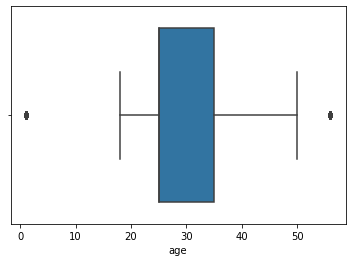

In [16]:
sns.boxplot(x="age", data=df_users)

In [17]:
print('num less than 18 = ',len(df_users[df_users['age'] == 1]))
df_users[df_users['age'] < 18]

num less than 18 =  222


,userId,gender,age,occupation,zip-code
0,1,1,1,10,48067
18,19,0,1,10,48073
50,51,1,1,10,10562
74,75,1,1,10,1748
85,86,1,1,10,54467
...,...,...,...,...,...
5843,5844,1,1,10,2131
5952,5953,0,1,10,21030
5972,5973,0,1,10,54701
5988,5989,1,1,10,74114


num less than 18 =  0


<AxesSubplot:xlabel='age'>

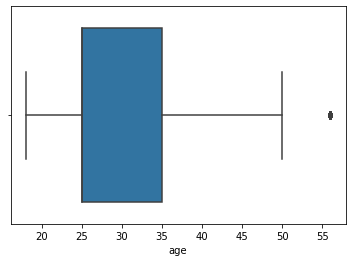

In [18]:
df_users.drop(df_users[df_users['age'] < 18].index,axis = 0,inplace=True)
df_users.reset_index(inplace=True)
df_users.drop(['index'],axis = 1,inplace=True)
print('num less than 18 = ',len(df_users[df_users['age'] < 18]))
sns.boxplot(x="age", data=df_users)

In [19]:
from uszipcode import SearchEngine

# Initialize the zip-code search engine
search = SearchEngine() 

# Define a function to get the state for a zip-code
def get_state(zipcode):    
    result = search.by_zipcode(zipcode)
    if result:
        return result.state
    else:
        return None

In [20]:
df_users['state'] = df_users['zip-code'].apply(get_state)
df_users

,userId,gender,age,occupation,zip-code,state
0,2,0,56,16,70072,LA
1,3,0,25,15,55117,MN
2,4,0,45,7,2460,MA
3,5,0,25,20,55455,MN
4,6,1,50,9,55117,MN
...,...,...,...,...,...,...
5813,6036,1,25,15,32603,FL
5814,6037,1,45,1,76006,TX
5815,6038,1,56,1,14706,NY
5816,6039,1,45,0,1060,MA


In [21]:
for column in df_users.columns:
    print (column , "unique len = " , len(df_users[column].unique()))

userId unique len =  5818
gender unique len =  2
age unique len =  6
occupation unique len =  21
zip-code unique len =  3335
state unique len =  56


In [22]:
state_Encoder = LabelEncoder()
df_users['state'] = state_Encoder.fit_transform(df_users['state'])
df_users

,userId,gender,age,occupation,zip-code,state
0,2,0,56,16,70072,21
1,3,0,25,15,55117,26
2,4,0,45,7,2460,22
3,5,0,25,20,55455,26
4,6,1,50,9,55117,26
...,...,...,...,...,...,...
5813,6036,1,25,15,32603,11
5814,6037,1,45,1,76006,47
5815,6038,1,56,1,14706,37
5816,6039,1,45,0,1060,22


In [23]:
joblib.dump(state_Encoder, 'state_Encoder.h5')

['state_Encoder.h5']

In [24]:
#df_users.drop(['userId','zip-code'],axis=1,inplace=True)
df_users.drop(['zip-code'],axis=1,inplace=True)
df_users.info()
df_users.describe().T
df_users


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5818 entries, 0 to 5817
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   userId      5818 non-null   int64
 1   gender      5818 non-null   int64
 2   age         5818 non-null   int64
 3   occupation  5818 non-null   int64
 4   state       5818 non-null   int32
dtypes: int32(1), int64(4)
memory usage: 204.7 KB


,userId,gender,age,occupation,state
0,2,0,56,16,21
1,3,0,25,15,26
2,4,0,45,7,22
3,5,0,25,20,26
4,6,1,50,9,26
...,...,...,...,...,...
5813,6036,1,25,15,11
5814,6037,1,45,1,47
5815,6038,1,56,1,37
5816,6039,1,45,0,22


In [25]:
for column in df_users.columns:
    print (column , "unique len = " , len(df_users[column].unique()))

userId unique len =  5818
gender unique len =  2
age unique len =  6
occupation unique len =  21
state unique len =  56


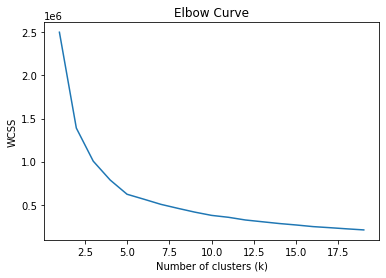

In [35]:
# Define range of k values to try
k_values = range(1, 20)

X = df_users[['gender', 'age', 'occupation', 'state']]
# Calculate WCSS for each k value
wcss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(k_values, wcss)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Curve')
plt.show()

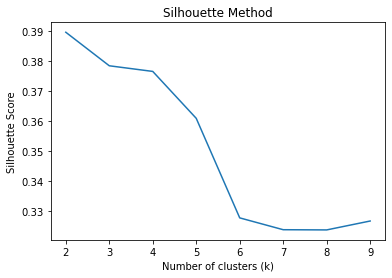

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Get features to cluster on
X = df_users[['gender', 'age', 'occupation', 'state']]

# Define range of k values to try
k_values = range(2, 10)

# Calculate silhouette score for each k value
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()


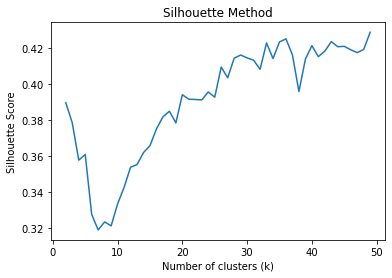

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Get features to cluster on
X = df_users[['gender', 'age', 'occupation', 'state']]

# Define range of k values to try
k_values = range(2, 50)

# Calculate silhouette score for each k value
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.plot(k_values, silhouette_scores)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [26]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_users.drop(columns='userId'))
labels = kmeans.labels_
df_users['cluster'] = labels
df_users

,userId,gender,age,occupation,state,cluster
0,2,0,56,16,21,4
1,3,0,25,15,26,1
2,4,0,45,7,22,4
3,5,0,25,20,26,1
4,6,1,50,9,26,4
...,...,...,...,...,...,...
5813,6036,1,25,15,11,2
5814,6037,1,45,1,47,0
5815,6038,1,56,1,37,0
5816,6039,1,45,0,22,4


In [27]:
df_merged = pd.merge(df_ratings, df_users, on='userId')
df_merged

,userId,movieId,rating,timestamp,gender,age,occupation,state,cluster
0,2,1357,5,978298709,0,56,16,21,4
1,2,3068,4,978299000,0,56,16,21,4
2,2,1537,4,978299620,0,56,16,21,4
3,2,647,3,978299351,0,56,16,21,4
4,2,2194,4,978299297,0,56,16,21,4
...,...,...,...,...,...,...,...,...,...
972993,6040,1091,1,956716541,0,25,6,37,3
972994,6040,1094,5,956704887,0,25,6,37,3
972995,6040,562,5,956704746,0,25,6,37,3
972996,6040,1096,4,956715648,0,25,6,37,3


In [28]:
df_merged = pd.merge(df_merged, df_movies, on='movieId')
df_merged

,userId,movieId,rating,timestamp,gender,age,occupation,state,cluster,title,genres
0,2,1357,5,978298709,0,56,16,21,4,Shine (1996),Drama|Romance
1,8,1357,4,978230800,0,25,12,37,3,Shine (1996),Drama|Romance
2,10,1357,5,978227625,1,35,1,6,2,Shine (1996),Drama|Romance
3,18,1357,5,978156876,1,18,3,6,2,Shine (1996),Drama|Romance
4,33,1357,4,978109488,0,45,3,26,4,Shine (1996),Drama|Romance
...,...,...,...,...,...,...,...,...,...,...,...
972993,5949,2198,5,958846401,0,18,17,18,1,Modulations (1998),Documentary
972994,5675,2703,3,976029116,0,35,14,12,2,Broken Vessels (1998),Drama
972995,5780,2845,1,958153068,0,18,17,6,2,White Boys (1999),Drama
972996,5851,3607,5,957756608,1,18,20,26,1,One Little Indian (1973),Comedy|Drama|Western


In [29]:
user = df_users.drop(columns='cluster',axis=0).iloc[0].values.reshape(1, -1)
user
result = kmeans.predict(user)[0]
result

c:\Users\gemy2\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


ValueError: X has 5 features, but KMeans is expecting 4 features as input.

In [ ]:
clustered_df = df_merged[df_merged['cluster'] == result]
clustered_df['title'].value_counts()[:5]

Star Wars                 2124
Star Trek                 1006
American Beauty (1999)     704
Mission                    661
Jurassic Park (1993)       571
Name: title, dtype: int64

In [ ]:
average_ratings = clustered_df.groupby('title')['rating'].mean()
sorted_ratings = average_ratings.sort_values(ascending=False)
sorted_ratings[:5]

title
Curdled (1996)                                                       5.0
Big Trees, The (1952)                                                5.0
Devil Girl From Mars (1954)                                          5.0
Institute Benjamenta, or This Dream People Call Human Life (1995)    5.0
Gate of Heavenly Peace, The (1995)                                   5.0
Name: rating, dtype: float64

In [30]:
joblib.dump(kmeans, 'cluster.h5')

['cluster.h5']